In [10]:
import sys
sys.path.append("/eos/home-m/mhassans/.local/lib/python2.7/site-packages")
!echo $PYTHONPATH
import ROOT
import uproot # can also use root_pandas or root_numpy
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools
%matplotlib inline
import pickle

/usr/local/lib/swan/extensions/:/cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/python:/cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages


In [22]:
#FUNCTIONS
def plot_roc_curve(fpr, tpr, auc,figname=''):
    SMALL_SIZE = 15
    MEDIUM_SIZE = 18
    BIGGER_SIZE = 29
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title  
    
    fig, ax = plt.subplots(figsize=(9,9))
    ax.plot(fpr, tpr)
    ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    ax.grid()
    ax.text(0.6, 0.3, 'ROC AUC Score: {:.3f}'.format(auc),
            bbox=dict(boxstyle='square,pad=0.3', fc='white', ec='k'))
    #lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
    lims = ((0,1))
    ax.plot(lims, lims, 'k--')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    if figname != '': plt.savefig(figname)
        
def plot_roc_curve_multi(fpr, tpr, label, fpr2, tpr2, label2):
    fig, ax = plt.subplots(figsize=(20,10))
    ax.plot(fpr, tpr, label=label)
    ax.plot(fpr2, tpr2, label= label2)
    ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    ax.grid()
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
    ax.plot(lims, lims, 'k--')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    leg=plt.legend() 
        
def plot_confusion_matrix(y_test, y_pred, classes,
                    figname, w_test=None, normalise_by_col=False, normalise_by_row=False,
                    cmap=plt.cm.Blues):
    if w_test is not None: cm = confusion_matrix(y_test, y_pred, sample_weight=w_test)
    else: cm = confusion_matrix(y_test, y_pred) 
    if normalise_by_col:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print ('Normalised efficiency confusion matrix')
    if normalise_by_row:
        cm = cm.astype('float') / cm.sum(axis=0)[np.newaxis, :]
        print ('Normalised purity confusion matrix')
    else:
        print ('Non-normalised confusion matrix')

    print (cm)

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.3f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='w' if cm[i, j] > thresh else 'k')

    plt.tight_layout(pad=1.4)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.savefig(figname)
    print ('Confusion matrix saved as {}'.format(figname))

    return None

def plot_eff_purity(x_bins, efficiency, purity, title, x_title):
    fig2 = plt.figure(figsize=(8,8))
    ax2 = fig2.add_subplot(111)
    ax2.plot(x_bins, purity, label='purity')
    ax2.plot(x_bins, efficiency, label='efficiency')
    leg=plt.legend(loc=3)
    ax2.grid()
    ax2.set_title(title)
    ax2.set_xlabel(x_title)

def plot_eff_purity_discr_power(real_threeprong, real_threeprong_pi0, real_other,\
                                which_score, normalized=False, yaxis='linear',\
                               real_threeprong_total=None, real_threeprong_pi0_total=None,\
                               real_other_total=None):
    #Plot discriminating power
    bins = np.linspace(0,1,30)
    fig1 = plt.figure(figsize=(8,8))
    ax1 = fig1.add_subplot(111)
    real_threeprong[which_score].hist(bins=bins, histtype=u'step', lw=3, label='real threeprong', density=normalized)
    real_threeprong_pi0[which_score].hist(bins=bins, histtype=u'step', lw=3, label='real threeprong+pi0', density=normalized)
    real_other[which_score].hist(bins=bins, histtype=u'step', lw=3, label='real other', density=normalized)
    leg = plt.legend(loc=2)
    plt.yscale(yaxis)
    if (which_score.split("_")[-1]!='pi0'):
        ax1.set_title(which_score.split("_")[-1] + " discriminating power")
        ax1.set_xlabel(which_score.split("_")[-1] + " MVA score")
    else:
        ax1.set_title("threeprong+pi0 discriminating power")
        ax1.set_xlabel("threeprong+pi0 MVA score")       

    #Plot eff and purity
    if (which_score.split("_")[-1]=='threeprong'):
        if (real_threeprong_total is None):
            real_threeprong_total=real_threeprong        
        real_threeprong_array_total = np.histogram(real_threeprong_total[which_score], bins=bins)[0] #For efficiency
        real_threeprong_array = np.histogram(real_threeprong[which_score], bins=bins)[0] #For purity
        threeprong_plus_fakethreeprong = np.histogram(real_threeprong[which_score], bins=bins)[0] \
            + np.histogram(real_threeprong_pi0[which_score], bins=bins)[0] \
            + np.histogram(real_other[which_score],bins=bins)[0]
        x_bins = np.delete(np.histogram(real_threeprong[which_score], bins=bins)[1], -1) #it is just bins
        eff_threeprong = np.zeros(len(x_bins))
        purity_threeprong = np.zeros(len(x_bins))
        for i in range(len(x_bins)):
            eff_threeprong[i] = float(sum(real_threeprong_array[i:]))/sum(real_threeprong_array_total[:])
            if (sum(threeprong_plus_fakethreeprong[i:]!=0)):
                purity_threeprong[i] = float(sum(real_threeprong_array[i:]))/sum(threeprong_plus_fakethreeprong[i:])
        plot_eff_purity(x_bins, eff_threeprong, purity_threeprong, 'threeprong discriminating power', 'threeprong MVA score')
    
    if (which_score.split("_")[-1]=='pi0'):
        if (real_threeprong_pi0_total is None):
            real_threeprong_pi0_total=real_threeprong_pi0        
        real_threeprong_pi0_array_total = np.histogram(real_threeprong_pi0_total[which_score], bins=bins)[0] #For efficiency
        real_threeprong_pi0_array = np.histogram(real_threeprong_pi0[which_score], bins=bins)[0] #For purity
        threeprong_pi0_plus_fakethreeprong_pi0 = np.histogram(real_threeprong[which_score], bins=bins)[0] \
                + np.histogram(real_threeprong_pi0[which_score], bins=bins)[0] \
                + np.histogram(real_other[which_score],bins=bins)[0]
        x_bins = np.delete(np.histogram(real_threeprong_pi0[which_score], bins=bins)[1], -1) #it is just bins
        eff_threeprong_pi0 = np.zeros(len(x_bins))
        purity_threeprong_pi0 = np.zeros(len(x_bins))
        for i in range(len(x_bins)):
            eff_threeprong_pi0[i] = float(sum(real_threeprong_pi0_array[i:]))/sum(real_threeprong_pi0_array_total[:])
            if(sum(threeprong_pi0_plus_fakethreeprong_pi0[i:])!=0): 
                purity_threeprong_pi0[i] = float(sum(real_threeprong_pi0_array[i:]))/sum(threeprong_pi0_plus_fakethreeprong_pi0[i:])
        plot_eff_purity(x_bins, eff_threeprong_pi0, purity_threeprong_pi0, 'threeprong_pi0 discriminating power', 'threeprong_pi0 MVA score')
        
    if (which_score.split("_")[-1]=='other'):
        if (real_other_total is None):
            real_other_total=real_other        
        real_other_array_total = np.histogram(real_other_total[which_score], bins=bins)[0] #For efficiency
        real_other_array = np.histogram(real_other[which_score], bins=bins)[0] #For purity
        other_plus_fakeother = np.histogram(real_threeprong[which_score], bins=bins)[0] \
                + np.histogram(real_threeprong_pi0[which_score], bins=bins)[0] \
                + np.histogram(real_other[which_score],bins=bins)[0]
        x_bins = np.delete(np.histogram(real_other[which_score], bins=bins)[1], -1) # number of bins is always 1 more than the other
        eff_other = np.zeros(len(x_bins))
        purity_other = np.zeros(len(x_bins))
        for i in range(len(x_bins)): 
            eff_other[i] = float(sum(real_other_array[i:]))/sum(real_other_array_total[:])
            if(sum(other_plus_fakeother[i:])!=0): 
                purity_other[i] = float(sum(real_other_array[i:]))/sum(other_plus_fakeother[i:])
        plot_eff_purity(x_bins, eff_other, purity_other, 'other discriminating power', 'other MVA score')






In [12]:
X_odd = pd.read_pickle("X_odd.pkl")

In [13]:
y_odd = pd.read_pickle("y_odd.pkl")

In [14]:
w_odd = pd.read_pickle("w_odd.pkl")

In [15]:
proba_even = pd.read_pickle("proba_even.pkl")

In [16]:
predict_even = pd.read_pickle("predict_even.pkl")

In [17]:
xgb_clf_even = pd.read_pickle("mvadm_inclusive_2fold_applytoodd.pkl")

/cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.19.1 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [3]:
#with open ("X_odd.pkl",'r') as f:
#    X_odd = pickle.load(f)

In [4]:
#with open ("y_odd.pkl",'r') as f:
#    y_odd = pickle.load(f)

In [5]:
#with open ("w_odd.pkl",'r') as f:
#    w_odd = pickle.load(f)

In [6]:
#with open ("proba_even.pkl",'r') as f:
#    proba_even = pickle.load(f)

In [7]:
#with open ("predict_even.pkl",'r') as f:
#    predict_even = pickle.load(f)

In [8]:
#with open ("mvadm_inclusive_2fold_applytoodd.pkl",'r') as f:
#    xgb_clf_even = pickle.load(f)

/cvmfs/sft.cern.ch/lcg/views/LCG_95a/x86_64-centos7-gcc7-opt/lib/python2.7/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.19.1 when using version 0.19.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [18]:
onehot_even=label_binarize(y_odd,classes=[0,1,2])
fpr_even=dict()
tpr_even=dict()
thresh_even = dict()
roc_auc_even=dict()
for i in range(3):
    fpr_even[i], tpr_even[i], thresh_even[i] = roc_curve(onehot_even[:,i], proba_even[:,i],sample_weight=w_odd)
    roc_auc_even[i] = auc(fpr_even[i], tpr_even[i],reorder=True)

/cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/sklearn/metrics/ranking.py:103: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/sklearn/metrics/ranking.py:103: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/sklearn/metrics/ranking.py:103: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reo

In [19]:
roc_auc_even

{0: 0.8348388155563776, 1: 0.9005199015616807, 2: 0.8837526834159721}

In [20]:
#other=0
#threeprong=1
#threeprong+pi0=2

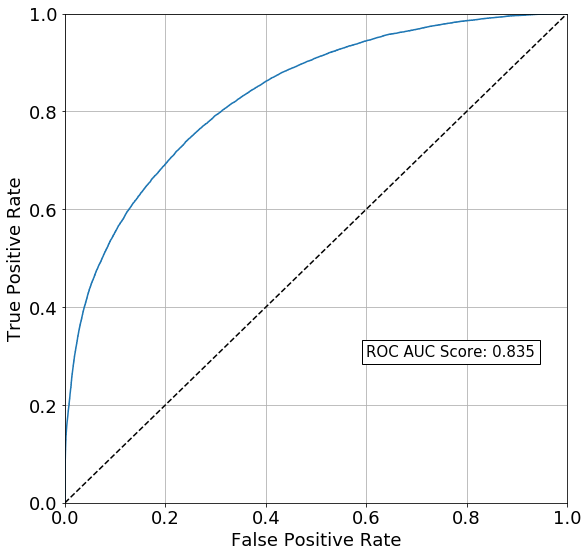

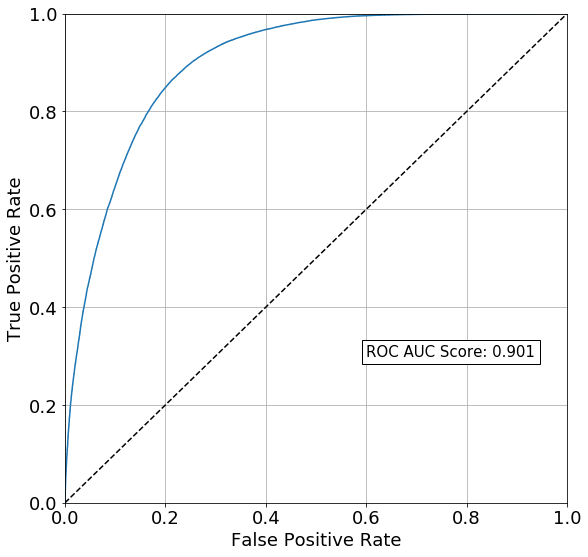

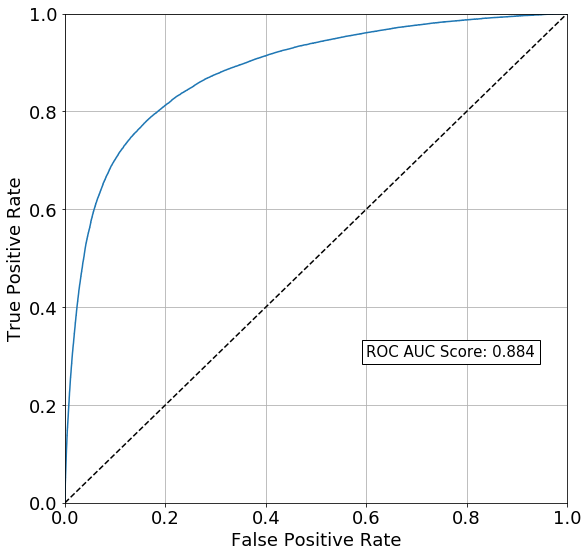

In [23]:
plot_roc_curve(fpr_even[0],tpr_even[0],roc_auc_even[0])
plot_roc_curve(fpr_even[1],tpr_even[1],roc_auc_even[1])
plot_roc_curve(fpr_even[2],tpr_even[2],roc_auc_even[2])


Normalised purity confusion matrix
[[0.63347763 0.06600684 0.14904894]
 [0.17215007 0.83436922 0.11947319]
 [0.19437229 0.09962394 0.73147787]]
Confusion matrix saved as purtiy_2fold_even
Normalised efficiency confusion matrix
Non-normalised confusion matrix
[[0.35798744 0.37715078 0.26486178]
 [0.01916173 0.93902135 0.04181691]
 [0.05550634 0.28764809 0.65684558]]
Confusion matrix saved as efficiency_2fold_even


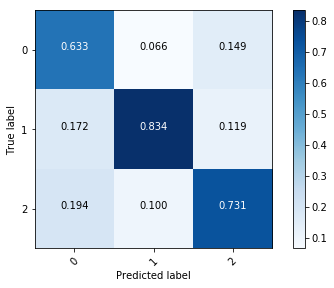

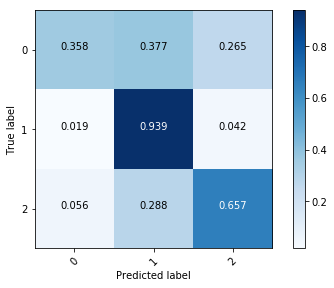

In [13]:

plot_confusion_matrix(y_odd, predict_even, [0,1,2],
                    'purtiy_2fold_even', normalise_by_row=True)
plot_confusion_matrix(y_odd, predict_even, [0,1,2],
                    'efficiency_2fold_even', normalise_by_col=True)

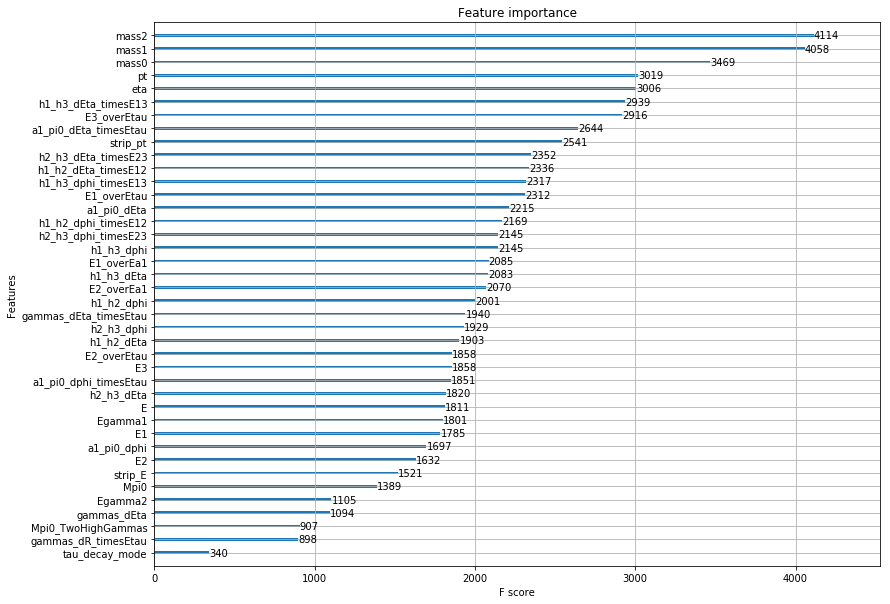

In [14]:
fig, ax = plt.subplots(figsize=(13,10))
xgb.plot_importance(xgb_clf_even,ax, importance_type='weight')

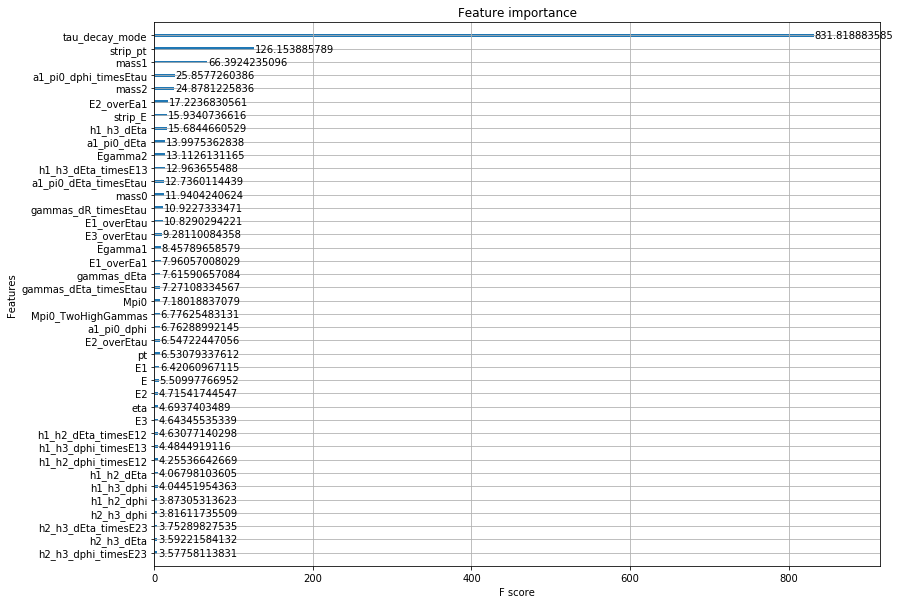

In [15]:
fig, ax = plt.subplots(figsize=(13,10))
xgb.plot_importance(xgb_clf_even,ax, importance_type='gain')

# Discriminating power plots

In [16]:
#other=0
#threeprong=1
#threeprong+pi0=2
data_prob_even=pd.DataFrame(proba_even)
data_prob_even.columns=['Score_other','Score_threeprong','Score_threeprong_pi0']
data_prob_even["label"]=y_odd.values
data_prob_even["predicted"]=predict_even
#data_prob_even["tau_decay_mode"]=X_odd["tau_decay_mode"].values
data_prob_even["pt"]=X_odd["pt"].values

In [17]:
real_other_even=data_prob_even[(data_prob_even["label"]==0)]
real_threeprong_even=data_prob_even[(data_prob_even["label"]==1)]
real_threeprong_pi0_even=data_prob_even[(data_prob_even["label"]==2)] 

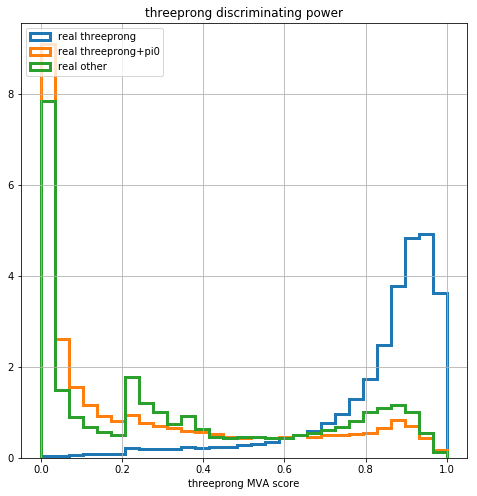

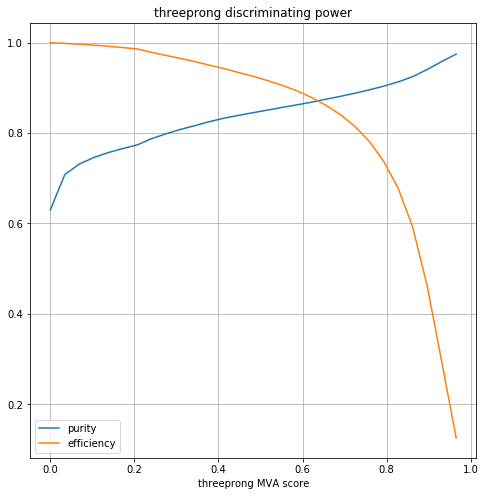

In [18]:
#Eff and purity plots for threeprong reconstruction
plot_eff_purity_discr_power(real_threeprong=real_threeprong_even,\
                            real_threeprong_pi0=real_threeprong_pi0_even, \
                            real_other=real_other_even,\
                            which_score="Score_threeprong", normalized=True)

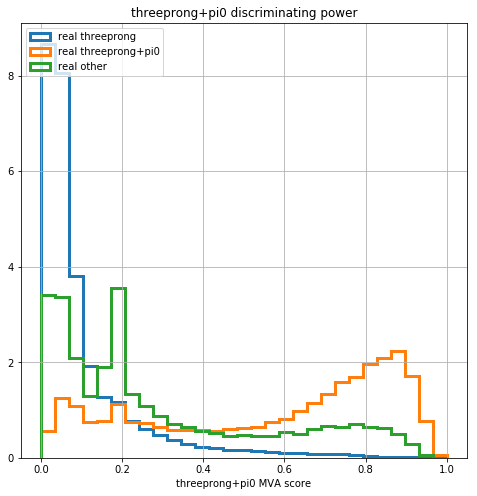

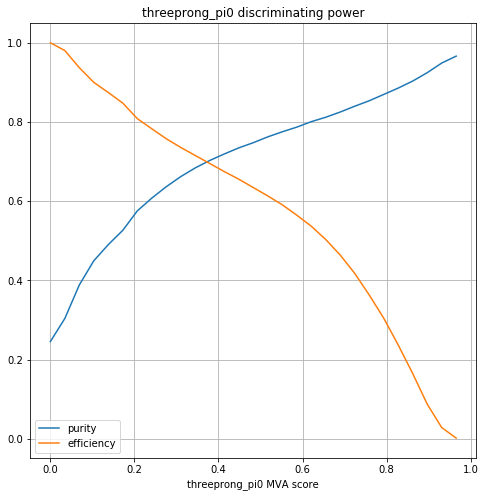

In [19]:
#Eff and purity plots for threeprong+pi0 reconstruction
plot_eff_purity_discr_power(real_threeprong=real_threeprong_even,\
                            real_threeprong_pi0=real_threeprong_pi0_even, \
                            real_other=real_other_even,\
                            which_score="Score_threeprong_pi0", normalized=True)

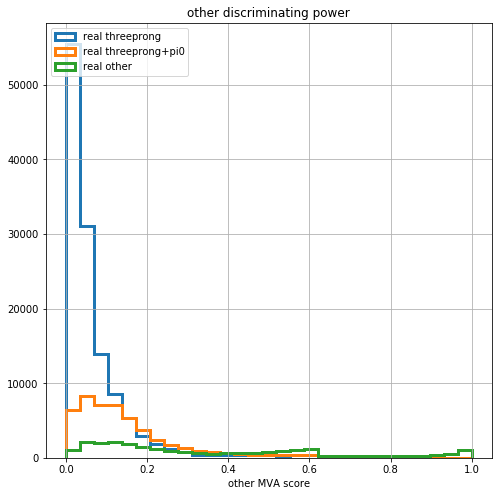

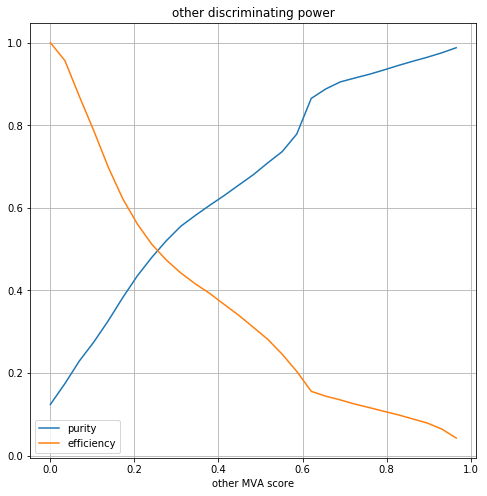

In [20]:
#Eff and purity plots for other reconstruction
plot_eff_purity_discr_power(real_threeprong=real_threeprong_even,\
                            real_threeprong_pi0=real_threeprong_pi0_even, \
                            real_other=real_other_even,\
                            which_score="Score_other", normalized=False)

In [21]:

data_prob_even_PredAsOther=data_prob_even[(data_prob_even["predicted"]==0)]
data_prob_even_PredAsthreeprong=data_prob_even[(data_prob_even["predicted"]==1)]
data_prob_even_PredAsthreeprong_pi0=data_prob_even[(data_prob_even["predicted"]==2)]
#---------------------------------------------------------------------------
real_other_even_PredAsOther=data_prob_even_PredAsOther[data_prob_even_PredAsOther['label']==0]
real_threeprong_even_PredAsOther=data_prob_even_PredAsOther[data_prob_even_PredAsOther['label']==1]
real_threeprong_pi0_even_PredAsOther=data_prob_even_PredAsOther[data_prob_even_PredAsOther['label']==2]

real_other_even_PredAsthreeprong=data_prob_even_PredAsthreeprong[data_prob_even_PredAsthreeprong['label']==0]
real_threeprong_even_PredAsthreeprong=data_prob_even_PredAsthreeprong[data_prob_even_PredAsthreeprong['label']==1]
real_threeprong_pi0_even_PredAsthreeprong=data_prob_even_PredAsthreeprong[data_prob_even_PredAsthreeprong['label']==2]

real_other_even_PredAsthreeprong_pi0=data_prob_even_PredAsthreeprong_pi0[data_prob_even_PredAsthreeprong_pi0['label']==0]
real_threeprong_even_PredAsthreeprong_pi0=data_prob_even_PredAsthreeprong_pi0[data_prob_even_PredAsthreeprong_pi0['label']==1]
real_threeprong_pi0_even_PredAsthreeprong_pi0=data_prob_even_PredAsthreeprong_pi0[data_prob_even_PredAsthreeprong_pi0['label']==2]

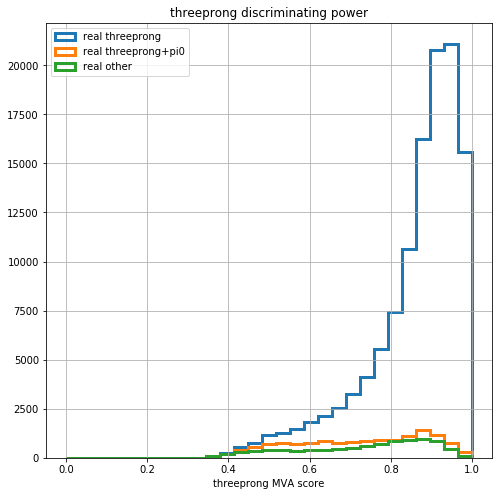

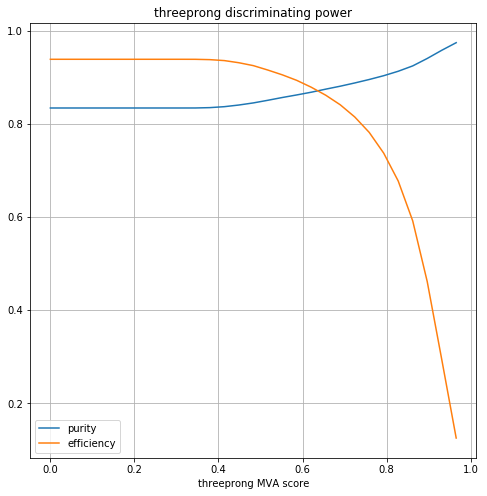

In [22]:

plot_eff_purity_discr_power(real_threeprong=real_threeprong_even_PredAsthreeprong,\
                            real_threeprong_pi0=real_threeprong_pi0_even_PredAsthreeprong, \
                            real_other=real_other_even_PredAsthreeprong,\
                            which_score="Score_threeprong", normalized=False,\
                           real_threeprong_total=real_threeprong_even)

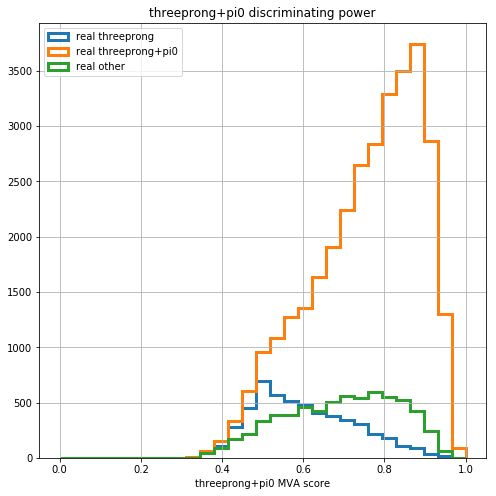

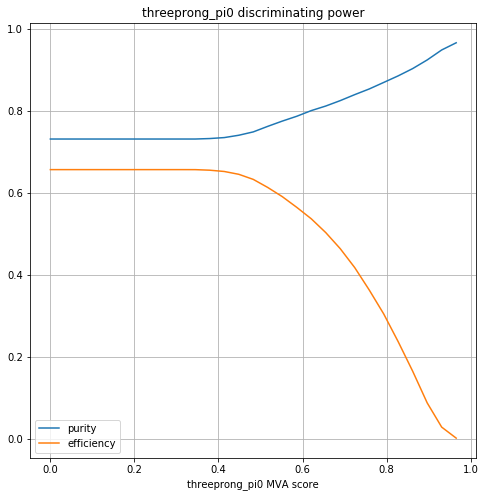

In [23]:

plot_eff_purity_discr_power(real_threeprong=real_threeprong_even_PredAsthreeprong_pi0,\
                            real_threeprong_pi0=real_threeprong_pi0_even_PredAsthreeprong_pi0, \
                            real_other=real_other_even_PredAsthreeprong_pi0,\
                            which_score="Score_threeprong_pi0", normalized=False,\
                            real_threeprong_pi0_total=real_threeprong_pi0_even)

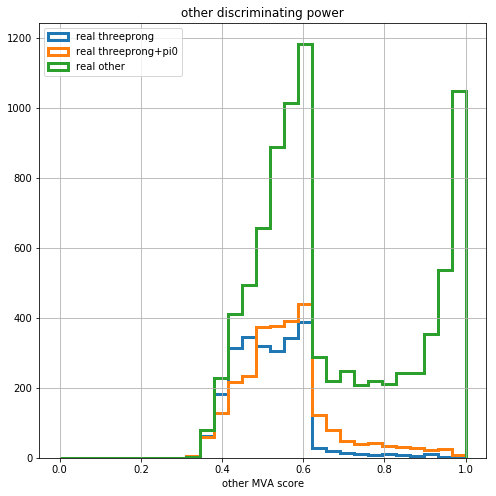

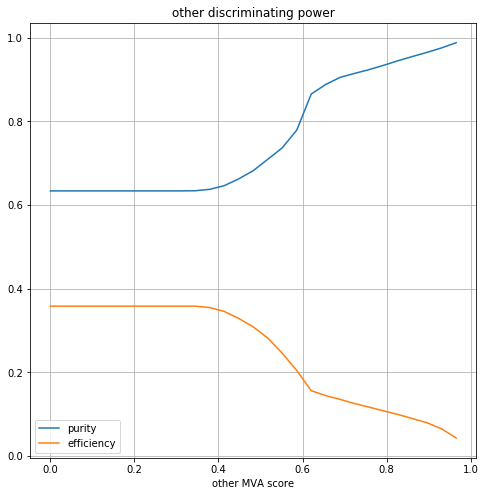

In [24]:
#Eff and purity plots for other reconstruction
plot_eff_purity_discr_power(real_threeprong=real_threeprong_even_PredAsOther,\
                            real_threeprong_pi0=real_threeprong_pi0_even_PredAsOther, \
                            real_other=real_other_even_PredAsOther,\
                            which_score="Score_other", normalized=False,\
                            real_other_total=real_other_even)

# ------THE NOTEBOOK FINISHES HERE----------